In [87]:
import sys
import numpy as np
np.set_printoptions(suppress=True, precision=4)
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option("display.max_rows", None, "display.max_columns", None)
pd.options.display.float_format = '{:,.4f}'.format
import seaborn as sns
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import IsolationForest
from sklearn.metrics import log_loss, make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.metrics import BinaryCrossentropy
from methods import *
import torch
import pickle, os
import skopt
from skopt import BayesSearchCV, gp_minimize
from skopt.space import Integer
from skopt.space import Real
from skopt.space import Categorical
from skopt.utils import use_named_args
import shutil
import warnings
warnings.filterwarnings("ignore")
print('done')

done


In [40]:
%load_ext autoreload
%autoreload 2
print('done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
done


In [90]:
def binarize_probabilities(probas, thresh):
    p = np.copy(probas)
    mask_lower = np.where(probas <= thresh)
    mask_higher = np.where(probas > thresh)
    p[mask_lower] = 0
    p[mask_higher] = 1
    return p

Using diffs
Using diffs
(1008, 12) (1008,)
(288, 12) (288,)
(288,) (288,)
metamodel_07_svm_round3_LR_square35_RANDOM_filters_all-classes.pickle
Log-Loss  = 0.9396282264012243
Accuracy  = 0.6875
Precision = 0.6776315789473685
Recall    = 0.7152777777777778
ROC AUC   = 0.6875
Confusion Matrix:
 [[ 95  49]
 [ 41 103]]


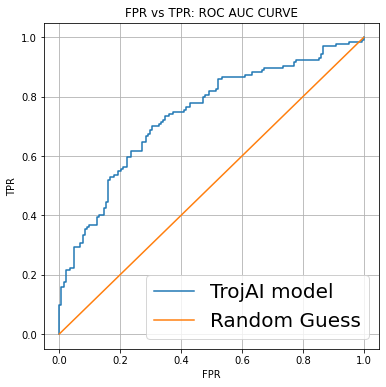

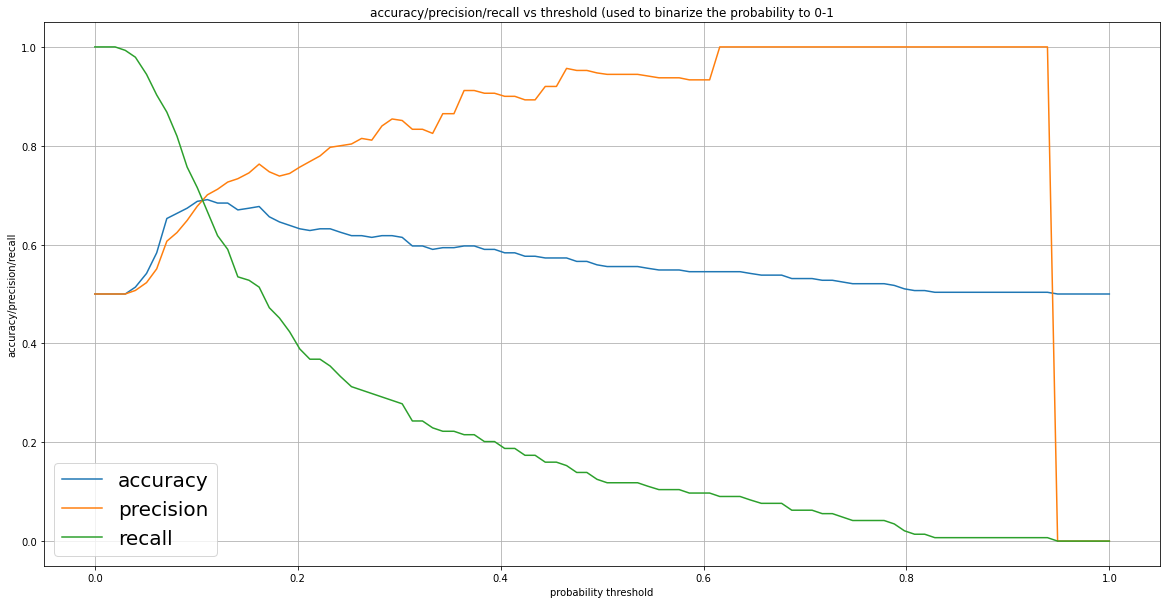

Log-Loss: inf


,model_name,model_architecture,trigger_type_aux,poisoned,pred_proba,log-loss
0,id-00000000,densenet121,none,False,0.0344,nan
1,id-00000001,resnet50,polygon-8,True,0.1052,nan
2,id-00000002,resnet152,instagram-kelvin,True,0.2796,nan
3,id-00000003,resnet152,none,False,0.0576,nan
4,id-00000004,shufflenet1_0,instagram-lomo,True,0.0484,inf
5,id-00000005,resnet101,polygon-3,True,0.1048,nan
6,id-00000006,inceptionv3,polygon-4,True,0.1496,nan
7,id-00000007,squeezenetv1_0,polygon-8,True,0.3045,nan
8,id-00000008,densenet161,polygon-9,True,0.2519,nan
9,id-00000009,mobilenetv2,instagram-lomo,True,0.0647,inf


In [125]:
path_meta_model = '../metamodels/metamodel_07_svm_round3_LR_square35_RANDOM_filters_all-classes.pickle'
path_train = r'confusion-reports\ics_fc\round3-train-dataset\round3-train-dataset_fc_square-30-random_filters.csv'
path_holdout = r'confusion-reports\ics_fc\round3-holdout-dataset\round3-holdout-dataset_fc_square-30-random_filters.csv'

meta_model = load_obj(path_meta_model)
positive_class_index = np.where(meta_model.classes_ == 1)[0][0]

X_train, y_train = read_features(path_train, trigger_type_aux_str=None, arch=None, data='diffs', append_arch=False, arch_one_hot=False)
X_holdout, y_holdout = read_features(path_holdout, trigger_type_aux_str=None, arch=None, data='diffs', append_arch=False, arch_one_hot=False) 

y_proba = meta_model.predict_proba(X_holdout)[:, positive_class_index]
y_pred = meta_model.predict(X_holdout)
y_thresh = binarize_probabilities(y_proba, 0.1)

print(X_train.shape, y_train.shape)
print(X_holdout.shape, y_holdout.shape)
print(y_proba.shape, y_pred.shape)

score_ce = log_loss(y_true=y_holdout, y_pred=y_proba)
score_accuracy = accuracy_score(y_true=y_holdout, y_pred=y_thresh)
score_precision = precision_score(y_true=y_holdout, y_pred=y_thresh)
score_recall = recall_score(y_true=y_holdout, y_pred=y_thresh)
score_conf_mat = confusion_matrix(y_true=y_holdout, y_pred=y_thresh)
score_roc_auc = roc_auc_score(y_holdout, y_thresh)

print(os.path.basename(path_meta_model))
print(f'Log-Loss  = {score_ce}')
print(f'Accuracy  = {score_accuracy}')
print(f'Precision = {score_precision}')
print(f'Recall    = {score_recall}')
print(f'ROC AUC   = {score_roc_auc}')
print('Confusion Matrix:\n', score_conf_mat)

fpr, tpr, thresholds = roc_curve(y_holdout, y_proba)
plt.figure(figsize=(6,6)).patch.set_color('white')
plt.plot(fpr, tpr, label='TrojAI model')
plt.plot([0, 1], [0, 1], label='Random Guess')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('FPR vs TPR: ROC AUC CURVE')
plt.legend(prop={'size': 20})
plt.grid()
plt.show()


list_thresh = []
list_accuracy = []
list_precision = []
list_recall = []
for x in np.linspace(0, 1, 100):
    thresh = round(x, 3)
    binary_decision = binarize_probabilities(y_proba, thresh)
    list_thresh.append(thresh)
    list_accuracy.append(accuracy_score(y_true=y_holdout, y_pred=binary_decision))
    list_precision.append(precision_score(y_true=y_holdout, y_pred=binary_decision))
    list_recall.append(recall_score(y_true=y_holdout, y_pred=binary_decision))
plt.figure(figsize=(20, 10)).patch.set_color('white')
plt.plot(list_thresh, list_accuracy, label='accuracy')
plt.plot(list_thresh, list_precision, label='precision')
plt.plot(list_thresh, list_recall, label='recall')
plt.legend(prop={'size': 20})
plt.xlabel('probability threshold')
plt.ylabel('accuracy/precision/recall')
plt.title('accuracy/precision/recall vs threshold (used to binarize the probability to 0-1')
plt.grid()
plt.show()

holdout_columns = pd.read_csv(r'confusion-reports/round3-holdout-columns.csv')
df = pd.DataFrame(columns=['model_name', 'model_architecture', 'trigger_type_aux', 'poisoned', 'pred_proba'])
df['model_name'] = holdout_columns['model_name']
df['model_architecture'] = holdout_columns['model_architecture']
df['poisoned'] = holdout_columns['poisoned']
df['trigger_type_aux'] = holdout_columns['trigger_type_aux']
df['pred_proba'] = pd.Series(y_proba)
df['log-loss'] = -(y_holdout * np.log(y_thresh) + (1 - y_holdout) * np.log(1 - y_thresh)) / len(df)
print('Log-Loss:', df['log-loss'].sum())
df